This notebook will be used to make some adjustments to the default topography generated by the `regional_library`. The motivation here, primarily for my interests in the Shark Bay, WA region, is that this is a relatively small, relatively shallow region and we potentially need a higher horizontal and vertical resolution to resolve the important dynamical scales that influence temperature and circulation in this highly sensitive coastal area. 

Here, we'll load in all topography/bathymetry files, and start to play around with things to see what will best represent the bay. 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35415 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35415/status,
Dashboard: /proxy/35415/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44253,Workers: 4
Dashboard: /proxy/35415/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:46321,Total threads: 2
Dashboard: /proxy/46849/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:41117,


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/conventions.py:543: SerializationWarning: variable 'elevation' has multiple fill values {1e+20, -1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


elevation not in topog
mask not in topog
elevation not in topog


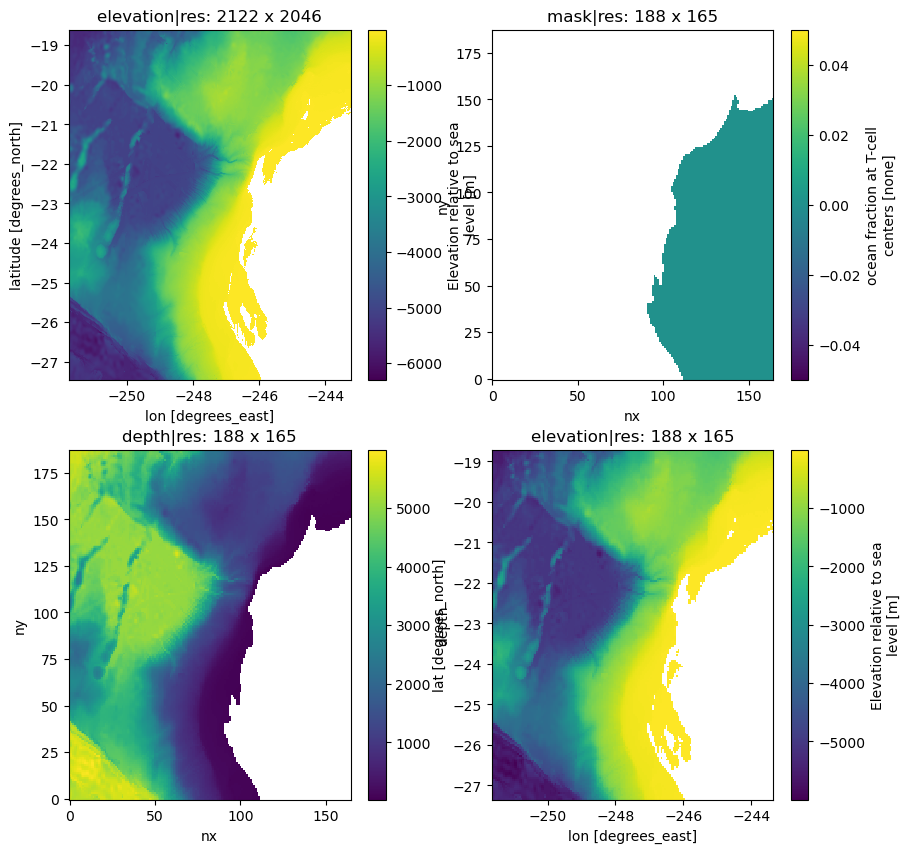

In [17]:
inputdir = '/scratch/v45/jr5971/mom6_regional_configs/sharkbay_iaf'

seafloor_ls = ['bathy_original', 'ocean_mask', 'topog', 'topog_raw']
seafloor_ds = []
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ds = xr.open_dataset(f"{inputdir}/{seafloor_ls[i]}.nc")
    seafloor_ds.append(ds)
    varname = list(ds.data_vars.keys())[0]
    if varname != 'depth':
        print(f'{varname} not in topog')
        var = ds[varname].where(ds[varname]<=0, drop=False)
        var.plot(ax=ax)
    else:
        var = ds[varname]
        var.plot(ax=ax)
    try:
        ax.set_title(f"{varname}|res: {len(var.lat)} x {len(var.lon)}")
    except:
        ax.set_title(f"{varname}|res: {len(var.ny)} x {len(var.nx)}")


Right, so this clears things up - the `topog_raw.nc` file has the original resolution - this should be as is on the hgrid and can be used. The only concern is that it has not been "deseas'd". 

We could just try using this topography and see how the model goes. 

In [92]:
def make_vgrid(vlayers, dz_ratio, depth):
    thickness = dz(vlayers, dz_ratio, depth)
    vcoord = xr.Dataset(
        {'zi':('zi', np.cumsum(thickness) -1),
         'zl':('zl', (np.cumsum(thickness) + 0.5 * thickness -1)[0:-1])}
    )
    vcoord['zi'].attrs = {'units':'meters'}
    return vcoord

def dz(npoints, ratio, target_depth, min_dz = 0.0001, tolerance=1):
    '''Recursive function; takes the target depth, the ratio between largest and smallest layer thicknesses,
    and generates a hyperbolic tangent thickness profile for the experiment.
    Iterates to find the minumum depth value which gives the target depth within some tolerance'''
    profile = min_dz + 0.5 * (np.abs(ratio) * min_dz - min_dz) * (1+np.tanh(2 * np.pi * (np.arange(npoints) - npoints//2) /npoints))
    tot = np.sum(profile)
    if np.abs(tot - target_depth) < tolerance:
        if ratio > 0:
            return profile
        return profile[::-1]
    err_ratio = target_depth / tot
    return dz(npoints, ratio, target_depth, min_dz * err_ratio)


In [93]:
# set parameters to test vertical coordinate shape.
vlayers = 100
dz_ratio = 40 # ratio of layer 0 to layer 'vlayers'
depth = 2000

vcoord = make_vgrid(vlayers, dz_ratio, depth)
dz_list.append(vcoord)
print(f"vcoord min-depth is {np.round(vcoord['zi'].min().values, 2)} metres")

vcoord min-depth is 0.06 metres


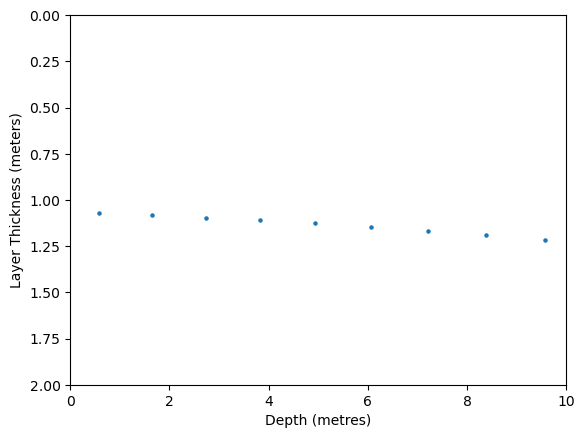

In [95]:
v_coord = vcoord
plt.scatter(v_coord.zl[:-1], np.diff(v_coord.zl), s=5)
plt.xlabel('Depth (metres)')
plt.ylabel('Layer Thickness (meters)')
plt.xlim(0,10)
plt.ylim(0,2)
plt.gca().invert_yaxis()



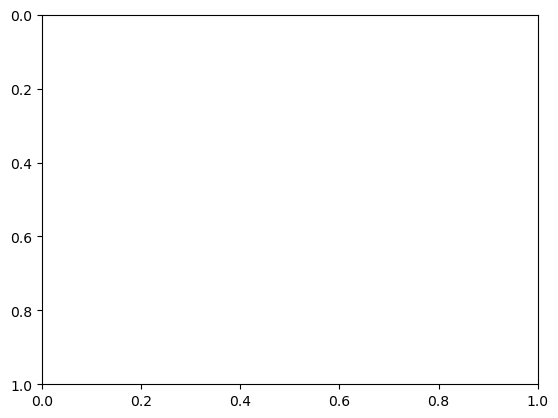

In [82]:
for v_coord in dz_list[-1]:
    plt.scatter(v_coord.zi[:-1], np.diff(v_coord.zi), s=5)
    plt.xlabel('Depth (metres)')
    plt.ylabel('Layer Thickness (meters)')

plt.xlim(0,20)
plt.ylim(0,5)
plt.gca().invert_yaxis()


In [11]:
seafloor_ds[2]

<xarray.Dataset>
Dimensions:  (ntiles: 1, ny: 188, nx: 165)
Coordinates:
    zi       float64 ...
Dimensions without coordinates: ntiles, ny, nx
Data variables:
    depth    (ntiles, ny, nx) float64 ...
Attributes:
    depth:          meters
    standard_name:  topographic depth at T-cell centers

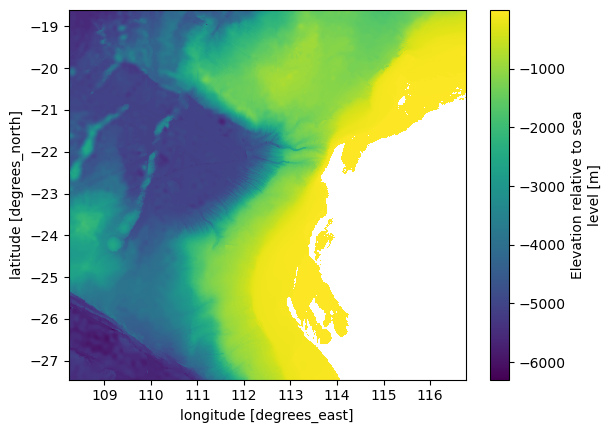

In [4]:
# gebco
gebco = "/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc"
lat = seafloor_ds[0].lat
lon = seafloor_ds[0].lon
yextent = [lat.min().values, lat.max().values]
xextent = [lon.min().values+360, lon.max().values+360]


ds = xr.open_dataset(gebco)['elevation']
geb_sharkbay = ds.sel(lat=slice(yextent[0], yextent[1]), 
                      lon=slice(xextent[0], xextent[1]))
geb_masked = geb_sharkbay.where(geb_sharkbay <= 0, drop=False)
geb_masked.plot()

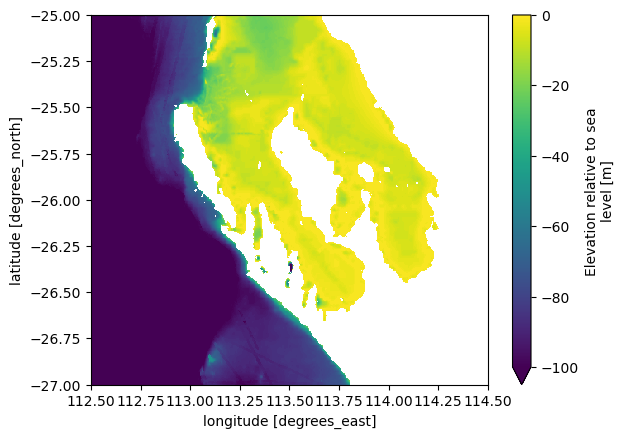

In [6]:
# close up of the sharkbay depth profile...
sharkbay_zoomed = geb_masked.sel(lat=slice(-27, -25), lon=slice(112.5, 114.5))
sharkbay_zoomed.plot(vmin = -100, vmax=0)

Well that's interesting - the bay is extremely shallow, whilst just offshore drops off rapidly to well over 100m. This could be quite a challenge to model in MOM6 as I'm not sure how well it'll do in a region this shallow. 

There's a few options here:
1. Run a coarser resolution model in a broader region, capturing the regional scale dynamics --> Then run a higher resolution model over a domain such as the one shown here. Forced by that other model. I would have to think about what the end goals are of performing such runs - what scales are we interested in? Is there interesting dynamics happening in Shark Bay that we are aiming to simulate? What about tides - we'd need to incorporate that into the model if looking this finer scale and this shallow. 

2. Look into the vertical layers, run a model that has a very large number of vertical layers in the first 10m, and then transitions to thicker layers more quickly. Although, in this region, we could have a max-depth of only around 500m, so it would be quite easy to have many layers at the surface. 

3. Let's think about the 1:5 grid-cell ratio at the open boundaries. This suggests that with the ACCESS-OM2-01 forcing at 0.1 degree, the maximum resolution we can have is 0.02 (or 50th degree). That's quite a big jump. It'd be interesting to do some tests comparing a smaller ratio and a bigger ratio, and looking at the interior energy etc., similar to Yuhang's talk. 

But, I really have to get back to some key research questions, now that I've got all this new functionality. Where am I going to run this regional model as a first go at IAF? What resolution? etc.

Ultimately I'm interested in Marine Heatwaves. NESP is interested in Shark Bay for reasons I don't totally understand as of yet. It might be time to put down the tools and start doing a bit more reading. Are there observations in the Shark Bay area that we could use to evaluate the model performance? Perhaps it's better to start this somewhere else where I could make better use of a large cluster of observations.
